In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
og_df = pd.read_csv('../out_LED.csv')
df = og_df[ og_df['repeat_trial'].isin([0,2]) | og_df['repeat_trial'].isna() ]
session_type = 7    
df = df[ df['session_type'].isin([session_type]) ]
training_level = 16
df = df[ df['training_level'].isin([training_level]) ]

t_stim_and_led_tuple = [(row['intended_fix'], row['LED_onset_time']) for _, row in df.iterrows()]

ABL_arr = df['ABL'].unique()
ABL_arr.sort()

ILD_arr = df['ILD'].unique()
ILD_arr.sort()

# percentage of LED on trials
frac_of_led = df['LED_trial'].values.sum() / df['LED_trial'].values.size
print(f'frac_of_led: {frac_of_led}')

frac_of_led: 0.33939811074203746


In [3]:
df_repeated_aborts_removed = df.copy()
repeated_abort_row_idx = []
# trial ids 
trial_ids = df_repeated_aborts_removed.index

for i in range(len(trial_ids)-1):
    current_trial = trial_ids[i]
    next_trial = trial_ids[i+1]

    if df_repeated_aborts_removed.loc[current_trial, 'abort_event'] == 3 \
        and df_repeated_aborts_removed.loc[current_trial, 'timed_fix'] > df_repeated_aborts_removed.loc[current_trial, 'LED_onset_time'] \
        and next_trial - current_trial == 1:

        ABL_match = df_repeated_aborts_removed.loc[current_trial, 'ABL'] == df_repeated_aborts_removed.loc[next_trial, 'ABL']
        ILD_match = df_repeated_aborts_removed.loc[current_trial, 'ILD'] == df_repeated_aborts_removed.loc[next_trial, 'ILD']
        LED_trial_match = df_repeated_aborts_removed.loc[current_trial, 'LED_trial'] == df_repeated_aborts_removed.loc[next_trial, 'LED_trial']


        if ABL_match and ILD_match and LED_trial_match:
            repeated_abort_row_idx.append(current_trial+1)


# the new df

In [4]:
df = df_repeated_aborts_removed.copy()

In [5]:
T_trunc = 0.3

# func to sample and shuffle

In [8]:
# concated df_led_on_sampled and df_led_off_sampled
import warnings

def shuffle_and_calc_diff(df):
        
        warnings.filterwarnings("ignore")

        df_led_on_truncated_aborts = df[
            (df['LED_trial'] == 1) & 
            (df['timed_fix'] < df['intended_fix']) & 
            (df['timed_fix'] > T_trunc)
        ].copy()

        df_led_off_truncated_aborts = df[
            (df['LED_trial'] == 0) & 
            (df['timed_fix'] < df['intended_fix']) & 
            (df['timed_fix'] > T_trunc)
        ].copy()

        # Define bins for stratification
        bin_width = 0.05
        bins = pd.interval_range(start=df['LED_onset_time'].min(), 
                                end=df['LED_onset_time'].max() + bin_width, 
                                freq=bin_width)

        # Assign strata based on bins
        df_led_on_truncated_aborts['strata'] = pd.cut(df_led_on_truncated_aborts['LED_onset_time'], bins=bins, labels=False)
        df_led_off_truncated_aborts['strata'] = pd.cut(df_led_off_truncated_aborts['LED_onset_time'], bins=bins, labels=False)

        # Find the minimum count for each stratum
        min_count_per_stratum = (
            pd.concat([
                df_led_on_truncated_aborts.groupby('strata').size(),
                df_led_off_truncated_aborts.groupby('strata').size()
            ], axis=1).min(axis=1)
        )

        # Perform stratified sampling
        df_led_on_sampled = (
            df_led_on_truncated_aborts.groupby('strata', group_keys=False)
            .apply(lambda group: group.sample(n=min_count_per_stratum.loc[group.name]))
        )

        df_led_off_sampled = (
            df_led_off_truncated_aborts.groupby('strata', group_keys=False)
            .apply(lambda group: group.sample(n=min_count_per_stratum.loc[group.name]))
        )

        frac_aborts_sampled_ON = len(df_led_on_sampled) / len(df_led_on_truncated_aborts)
        frac_aborts_sampled_OFF = len(df_led_off_sampled) / len(df_led_off_truncated_aborts)

        # num of non_aborts
        # LED ON(or OFF) - num of aborts
        num_non_aborts_ON = len(df[
            (df['LED_trial'] == 1) & 
            (df['success'].isin([1,-1]))
        ])
        num_non_aborts_OFF = len( df[
            (df['LED_trial'] == 0) & 
            (df['success'].isin([1,-1]))
        ])

        # frac of non_aborts to sample
        num_non_aborts_sample_ON = int(frac_aborts_sampled_ON * num_non_aborts_ON)
        num_non_aborts_sample_OFF = int(frac_aborts_sampled_OFF * num_non_aborts_OFF)

        # sample non_aborts
        df_non_aborts_ON = df[
            (df['LED_trial'] == 1) & 
            (df['success'].isin([1,-1]))
        ].sample(n=num_non_aborts_sample_ON)

        df_non_aborts_OFF = df[
            (df['LED_trial'] == 0) & 
            (df['success'].isin([1,-1]))
        ].sample(n=num_non_aborts_sample_OFF)


        # concatenate on off, aborts and non_aborts
        df_sampled = pd.concat([df_led_on_sampled, df_led_off_sampled, df_non_aborts_ON, df_non_aborts_OFF])


        df_sampled_shuffled = df_sampled.copy()


        # ----- SHUFFLE ----
        df_sampled_shuffled['LED_trial'] = np.random.permutation(df_sampled['LED_trial'].values)


        df_led_on_truncated_aborts_shuffled = df_sampled_shuffled[
            (df_sampled_shuffled['LED_trial'] == 1) &
            (df_sampled_shuffled['timed_fix'] < df_sampled_shuffled['intended_fix']) &
            (df_sampled_shuffled['timed_fix'] > T_trunc)
        ]
        df_led_off_truncated_aborts_shuffled = df_sampled_shuffled[
            (df_sampled_shuffled['LED_trial'] == 0) &
            (df_sampled_shuffled['timed_fix'] < df_sampled_shuffled['intended_fix']) &
            (df_sampled_shuffled['timed_fix'] > T_trunc)
        ]
            

        abort_rt_wrt_LED_ON_shuffled = df_led_on_truncated_aborts_shuffled['timed_fix'] - df_led_on_truncated_aborts_shuffled['LED_onset_time']
        abort_rt_wrt_LED_OFF_shuffled = df_led_off_truncated_aborts_shuffled['timed_fix'] - df_led_off_truncated_aborts_shuffled['LED_onset_time']

        hist_bins = np.arange(-1, 2, bin_width)

        abort_on_hist_shuffled, _ = np.histogram(abort_rt_wrt_LED_ON_shuffled, bins=hist_bins, density=True)
        abort_off_hist_shuffled, _ = np.histogram(abort_rt_wrt_LED_OFF_shuffled, bins=hist_bins, density=True)


        abort_on_hist_shuffled *= len(df_led_on_truncated_aborts_shuffled) / len(df_sampled_shuffled[df_sampled_shuffled['LED_trial'] == 1])
        abort_off_hist_shuffled *= len(df_led_off_truncated_aborts_shuffled) / len(df_sampled_shuffled[df_sampled_shuffled['LED_trial'] == 0])

        return abort_on_hist_shuffled - abort_off_hist_shuffled


In [9]:
from joblib import Parallel, delayed
N_shuffle = int(50e3)
warnings.filterwarnings("ignore")

all_shuffled_diffs = Parallel(n_jobs=-1)(delayed(shuffle_and_calc_diff)(df) for _ in range(N_shuffle))

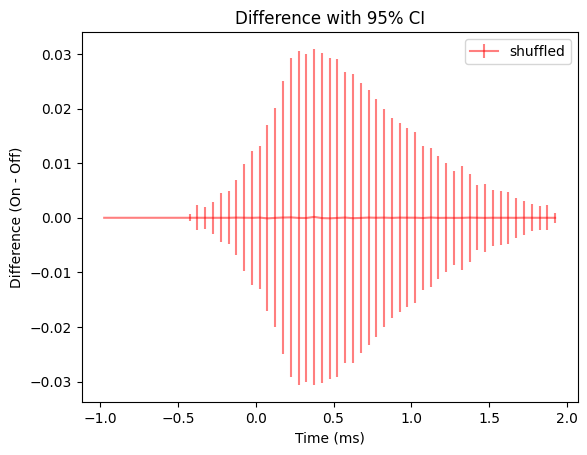

In [10]:
all_shuffled_diffs_np = np.array(all_shuffled_diffs)
hist_bins = np.arange(-1, 2, 0.05)
t_pts = hist_bins[:-1] + 0.5 * 0.05

mean = all_shuffled_diffs_np.mean(axis=0)
std = all_shuffled_diffs_np.std(axis=0)
n = all_shuffled_diffs_np.shape[0]
error_95ci = 1.96 * (std)
# Plot with 95% confidence intervals
plt.errorbar(t_pts, mean, yerr=error_95ci, color='r', alpha=0.5, label='shuffled')
plt.xlabel('Time (ms)')
plt.ylabel('Difference (On - Off)')
plt.legend()
plt.title('Difference with 95% CI')
plt.show()

# TODO - sampling but no shuffling

In [11]:
df_led_on_truncated_aborts = df[
    (df['LED_trial'] == 1) & 
    (df['timed_fix'] < df['intended_fix']) & 
    (df['timed_fix'] > T_trunc)
].copy()

df_led_off_truncated_aborts = df[
    (df['LED_trial'] == 0) & 
    (df['timed_fix'] < df['intended_fix']) & 
    (df['timed_fix'] > T_trunc)
].copy()

# Define bins for stratification
bin_width = 0.05
bins = pd.interval_range(start=df['LED_onset_time'].min(), 
                        end=df['LED_onset_time'].max() + bin_width, 
                        freq=bin_width)

# Assign strata based on bins
df_led_on_truncated_aborts['strata'] = pd.cut(df_led_on_truncated_aborts['LED_onset_time'], bins=bins, labels=False)
df_led_off_truncated_aborts['strata'] = pd.cut(df_led_off_truncated_aborts['LED_onset_time'], bins=bins, labels=False)

# Find the minimum count for each stratum
min_count_per_stratum = (
    pd.concat([
        df_led_on_truncated_aborts.groupby('strata').size(),
        df_led_off_truncated_aborts.groupby('strata').size()
    ], axis=1).min(axis=1)
)

# Perform stratified sampling
df_led_on_sampled = (
    df_led_on_truncated_aborts.groupby('strata', group_keys=False)
    .apply(lambda group: group.sample(n=min_count_per_stratum.loc[group.name]))
)

df_led_off_sampled = (
    df_led_off_truncated_aborts.groupby('strata', group_keys=False)
    .apply(lambda group: group.sample(n=min_count_per_stratum.loc[group.name]))
)

frac_aborts_sampled_ON = len(df_led_on_sampled) / len(df_led_on_truncated_aborts)
frac_aborts_sampled_OFF = len(df_led_off_sampled) / len(df_led_off_truncated_aborts)

# num of non_aborts
# LED ON(or OFF) - num of aborts
num_non_aborts_ON = len(df[
    (df['LED_trial'] == 1) & 
    (df['success'].isin([1,-1]))
])
num_non_aborts_OFF = len( df[
    (df['LED_trial'] == 0) & 
    (df['success'].isin([1,-1]))
])

# frac of non_aborts to sample
num_non_aborts_sample_ON = int(frac_aborts_sampled_ON * num_non_aborts_ON)
num_non_aborts_sample_OFF = int(frac_aborts_sampled_OFF * num_non_aborts_OFF)

# sample non_aborts
df_non_aborts_ON = df[
    (df['LED_trial'] == 1) & 
    (df['success'].isin([1,-1]))
].sample(n=num_non_aborts_sample_ON)

df_non_aborts_OFF = df[
    (df['LED_trial'] == 0) & 
    (df['success'].isin([1,-1]))
].sample(n=num_non_aborts_sample_OFF)


# concatenate on off, aborts and non_aborts
df_sampled = pd.concat([df_led_on_sampled, df_led_off_sampled, df_non_aborts_ON, df_non_aborts_OFF])



truncated_aborts_ON_wrt_LED = df_led_on_sampled['timed_fix'] - df_led_on_sampled['LED_onset_time']
truncated_aborts_OFF_wrt_LED = df_led_off_sampled['timed_fix'] - df_led_off_sampled['LED_onset_time']

hist_bins = np.arange(-1, 2, bin_width)

abort_on_hist, _ = np.histogram(truncated_aborts_ON_wrt_LED, bins=hist_bins, density=True)
abort_off_hist, _ = np.histogram(truncated_aborts_OFF_wrt_LED, bins=hist_bins, density=True)

abort_on_hist *= len(df_led_on_sampled) / len(df_sampled[df_sampled['LED_trial'] == 1])
abort_off_hist *= len(df_led_off_sampled) / len(df_sampled[df_sampled['LED_trial'] == 0])




Text(0.5, 1.0, 'Difference')

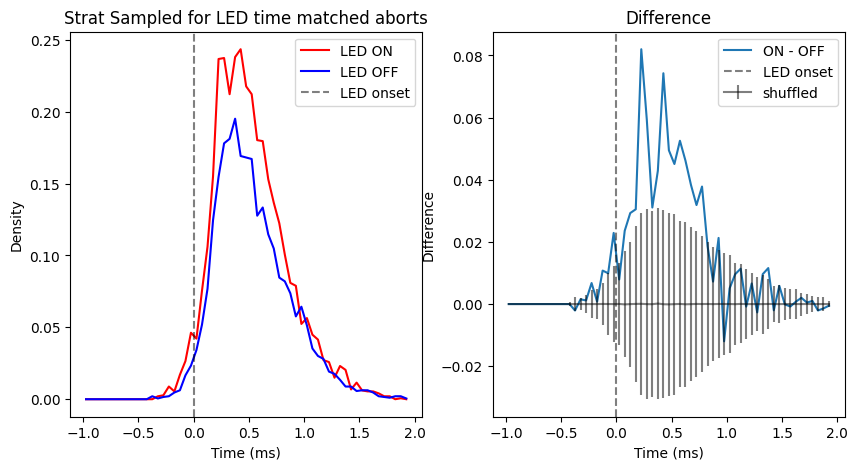

In [16]:
from cProfile import label


t_pts = hist_bins[:-1] + 0.5 * bin_width

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(t_pts, abort_on_hist, label='LED ON', color='r')
plt.plot(t_pts, abort_off_hist, label='LED OFF', color='b')
plt.axvline(x=0, color='k', linestyle='--', alpha=0.5, label='LED onset')

plt.xlabel('Time (ms)')
plt.ylabel('Density')
plt.legend()
plt.title('Strat Sampled for LED time matched aborts')

plt.subplot(1, 2, 2)
plt.plot(t_pts, abort_on_hist - abort_off_hist, label='ON - OFF')
plt.errorbar(t_pts, mean, yerr=error_95ci, color='k', alpha=0.5, label='shuffled')
plt.axvline(x=0, color='k', linestyle='--', alpha=0.5, label='LED onset')
plt.xlabel('Time (ms)')
plt.ylabel('Difference')
plt.legend()
plt.title('Difference')